In [1]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [2]:
!pip install streamlit

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import F for activation functions
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, roc_auc_score,
                             precision_recall_curve, average_precision_score,
                             classification_report)
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)


In [4]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Shuffle data
train = train.sample(frac=1, random_state=1).reset_index(drop=True)
test = test.sample(frac=1, random_state=1).reset_index(drop=True)

# Drop unnecessary columns
train.drop(['keyword', 'location'], axis=1, inplace=True)
test.drop(['keyword', 'location'], axis=1, inplace=True)


In [5]:
# Clean text function
def clean_text(text):
    # Remove unknown characters (emojis, etc.)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text)

    # Remove hashtags and mentions
    text = text.replace('#', ' ')
    text = text.replace('@', ' ')

    # Remove special characters
    symbols = re.compile(r'[^A-Za-z0-9 ]')
    text = symbols.sub(r'', text)

    # Convert to lowercase
    text = text.lower()

    return text

# Apply text cleaning
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))


In [6]:
# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.50d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Found {len(embeddings_index)} word vectors.')


Found 400000 word vectors.


In [7]:
# Prepare embeddings and word indices
word2idx = {}
new_embedding_index = {}

# Build vocabulary and embedding matrix
index = 1  # Start indexing from 1
for dataset in [train, test]:
    for x in dataset['text']:
        words = x.split()
        for word in words:
            if word not in word2idx:
                word2idx[word] = index
                if word in embeddings_index:
                    new_embedding_index[index] = embeddings_index[word]
                else:
                    new_embedding_index[index] = np.random.normal(scale=0.6, size=(50,)).astype(np.float32)
                index += 1

# Add zero vector for padding index
new_embedding_index[0] = np.zeros(50, dtype=np.float32)


In [8]:
# Save word2idx for later use
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)


In [9]:
# Convert text to index sequences
def text_to_sequence(text_list, word2idx):
    sequences = []
    for text in text_list:
        words = text.split()
        seq = [word2idx.get(word, 0) for word in words]
        sequences.append(seq)
    return sequences

train_sequences = text_to_sequence(train['text'], word2idx)
test_sequences = text_to_sequence(test['text'], word2idx)


In [10]:
# Padding sequences
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = np.array(seq[:maxlen])
        else:
            padded_sequences[i, -len(seq):] = np.array(seq)
    return padded_sequences

max_len = 55  # Based on max length observed
train_padded = pad_sequences(train_sequences, maxlen=max_len)
test_padded = pad_sequences(test_sequences, maxlen=max_len)


In [11]:
# Prepare target variable
train_labels = train['target'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=1)

# Create DataLoaders
batch_size = 64

# Convert to PyTorch tensors
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

# DataLoaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)


In [12]:
# Prepare embedding weights matrix
num_embeddings = len(new_embedding_index)
embedding_dim = 50
weights_matrix = np.zeros((num_embeddings, embedding_dim), dtype=np.float32)
for idx, vec in new_embedding_index.items():
    weights_matrix[idx] = vec
weights_matrix = torch.tensor(weights_matrix)


# Logistic Regression(Base model)

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 3. Prepare Labels
train_labels = train['target'].values

# 4. Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=1)

# 5. Create TensorDatasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(test_padded))  # only inputs for test set

# 6. Create DataLoaders
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

print("Train, Validation, and Test Loaders are ready!")

# 7. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# 8. Define Baseline Logistic Regression Model
class BaselineLogisticModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BaselineLogisticModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Define model input dimension correctly based on train_padded
embedding_dim = train_padded.shape[1]  # Automatically get correct dimension
print(f"Detected embedding dimension: {embedding_dim}")

baseline_model = BaselineLogisticModel(embedding_dim, 2)
baseline_model = baseline_model.to(device)

# 9. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

# 10. Define Train and Evaluate Functions
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in iterator:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.float()

        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return epoch_loss / len(iterator), accuracy

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in iterator:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()

            predictions = model(inputs)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return epoch_loss / len(iterator), accuracy

# Predict function for Test
def predict(model, iterator):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for inputs in iterator:
            inputs = inputs[0].to(device)  # only inputs in test
            inputs = inputs.float()

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds

# 11. Train the Baseline Model
EPOCHS = 500 # Training for 300 epochs

for epoch in range(EPOCHS):
    train_loss, train_acc = train(baseline_model, train_loader, baseline_optimizer, criterion)
    valid_loss, valid_acc = evaluate(baseline_model, valid_loader, criterion)

    # Print only every 20 epochs
    if (epoch + 1) % 20 == 0 or epoch == 0 or epoch == EPOCHS-1:
        print(f'Baseline Epoch {epoch+1}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%')

# 12. Predict on Test Set
all_preds = predict(baseline_model, test_loader)
print("Test Predictions Done!")
print("Sample Predictions:", all_preds[:10])


Train, Validation, and Test Loaders are ready!
Using device: cuda
Detected embedding dimension: 55
Baseline Epoch 1:
  Train Loss: 311.3795 | Train Acc: 50.80%
  Valid Loss: 111.7123 | Valid Acc: 50.23%
Baseline Epoch 20:
  Train Loss: 5.2467 | Train Acc: 50.34%
  Valid Loss: 6.4440 | Valid Acc: 49.31%
Baseline Epoch 40:
  Train Loss: 6.2487 | Train Acc: 50.67%
  Valid Loss: 5.8349 | Valid Acc: 56.40%
Baseline Epoch 60:
  Train Loss: 5.4495 | Train Acc: 50.44%
  Valid Loss: 5.1151 | Valid Acc: 50.43%
Baseline Epoch 80:
  Train Loss: 4.7717 | Train Acc: 51.64%
  Valid Loss: 12.0329 | Valid Acc: 42.09%
Baseline Epoch 100:
  Train Loss: 5.7712 | Train Acc: 51.36%
  Valid Loss: 5.5039 | Valid Acc: 49.31%
Baseline Epoch 120:
  Train Loss: 6.1657 | Train Acc: 50.89%
  Valid Loss: 10.8898 | Valid Acc: 43.34%
Baseline Epoch 140:
  Train Loss: 6.1376 | Train Acc: 51.40%
  Valid Loss: 7.1404 | Valid Acc: 48.00%
Baseline Epoch 160:
  Train Loss: 5.3970 | Train Acc: 52.56%
  Valid Loss: 7.3074 | V

<Figure size 800x600 with 0 Axes>

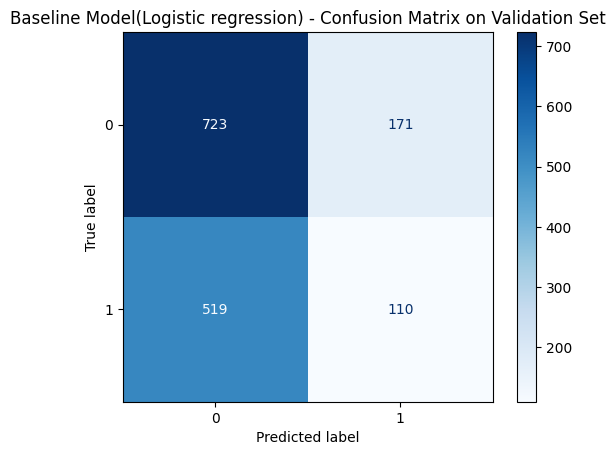

Classification Report:
              precision    recall  f1-score   support

           0     0.5821    0.8087    0.6770       894
           1     0.3915    0.1749    0.2418       629

    accuracy                         0.5469      1523
   macro avg     0.4868    0.4918    0.4594      1523
weighted avg     0.5034    0.5469    0.4972      1523



In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1. Get validation set predictions
baseline_model.eval()
val_preds = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        inputs = inputs.float()

        outputs = baseline_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        val_preds.extend(preds.cpu().numpy())

# y_val is your true labels (already created when splitting)
y_true = y_val  # numpy array of true validation labels

# 2. Create Confusion Matrix
cm = confusion_matrix(y_true, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# 3. Plot Confusion Matrix
plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Baseline Model(Logistic regression) - Confusion Matrix on Validation Set')
plt.show()

# 4. Classification Report
print("Classification Report:")
print(classification_report(y_true, val_preds, digits=4))


# BiLSTM model

In [15]:
class BiLSTM(nn.Module):
    def __init__(self, weights_matrix, output_size, hidden_dim, hidden_dim2, n_layers, drop_prob=0.5):
        super(BiLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Embedding layer
        num_embeddings, embedding_dim = weights_matrix.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embedding layer

        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, bidirectional=True, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_size)

        # Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # Embedding
        embeds = self.embedding(x)

        # LSTM
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Stack up LSTM outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        # Dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        # Sigmoid activation
        sig_out = self.sigmoid(out)

        # Reshape to batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # Get last batch of labels

        return sig_out, hidden

    def init_hidden(self, batch_size, train_on_gpu=False):
        weight = next(self.parameters()).data

        layers = self.n_layers * 2  # Multiply by 2 for bidirectionality
        if train_on_gpu:
            hidden = (weight.new(layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(layers, batch_size, self.hidden_dim).zero_())
        return hidden


In [16]:
# Instantiate the model
output_size = 1
hidden_dim = 128
hidden_dim2 = 64
n_layers = 2

net = BiLSTM(weights_matrix, output_size, hidden_dim, hidden_dim2, n_layers)
print(net)

# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    net.cuda()

# Loss and optimization functions
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


BiLSTM(
  (embedding): Embedding(22652, 50)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [17]:
# Training the model
epochs = 500  # You can increase this for better performance
clip = 5  # Gradient clipping
valid_loss_min = np.inf  # Track change in validation loss

train_losses_epoch = []
val_losses_epoch = []

net.train()
for epoch in range(epochs):
    train_losses = []
    for inputs, labels in train_loader:
        # Move data to GPU if available
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        # Initialize hidden state based on actual batch size
        h = net.init_hidden(inputs.size(0), train_on_gpu)

        # Create new variables for hidden state
        h = tuple([each.data for each in h])

        net.zero_grad()

        # Forward pass
        outputs, h = net(inputs, h)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(net.parameters(), clip)

        optimizer.step()
        train_losses.append(loss.item())

    train_losses_epoch.append(np.mean(train_losses))

    # Validation
    val_losses = []
    net.eval()
    y_preds = []
    y_true = []
    y_probs = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # Move data to GPU if available
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs, labels

            # Initialize hidden state based on actual batch size
            val_h = net.init_hidden(inputs.size(0), train_on_gpu)

            # Create new variables for hidden state
            val_h = tuple([each.data for each in val_h])

            outputs, val_h = net(inputs, val_h)
            val_loss = criterion(outputs.squeeze(), labels.float())
            val_losses.append(val_loss.item())

            # Save predictions for evaluation metrics
            probs = outputs.squeeze().detach().cpu().numpy()
            preds = torch.round(outputs.squeeze())
            y_probs.extend(probs)
            y_preds.extend(preds.detach().cpu().numpy())
            y_true.extend(labels.detach().cpu().numpy())

    val_losses_epoch.append(np.mean(val_losses))

    net.train()

    print(f"Epoch: {epoch+1}/{epochs}...",
          f"Train Loss: {np.mean(train_losses):.6f}...",
          f"Val Loss: {np.mean(val_losses):.6f}...")

    # Save model if validation loss has decreased
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(net.state_dict(), 'state_dict.pt')
        valid_loss_min = np.mean(val_losses)


Epoch: 1/500... Train Loss: 0.524765... Val Loss: 0.476718...
Epoch: 2/500... Train Loss: 0.461810... Val Loss: 0.450873...
Epoch: 3/500... Train Loss: 0.447960... Val Loss: 0.470441...
Epoch: 4/500... Train Loss: 0.432038... Val Loss: 0.452935...
Epoch: 5/500... Train Loss: 0.424539... Val Loss: 0.440656...
Epoch: 6/500... Train Loss: 0.414913... Val Loss: 0.446564...
Epoch: 7/500... Train Loss: 0.398690... Val Loss: 0.445776...
Epoch: 8/500... Train Loss: 0.387036... Val Loss: 0.450466...
Epoch: 9/500... Train Loss: 0.372013... Val Loss: 0.473906...
Epoch: 10/500... Train Loss: 0.363373... Val Loss: 0.460544...
Epoch: 11/500... Train Loss: 0.346242... Val Loss: 0.501684...
Epoch: 12/500... Train Loss: 0.324691... Val Loss: 0.575798...
Epoch: 13/500... Train Loss: 0.316343... Val Loss: 0.502731...
Epoch: 14/500... Train Loss: 0.302994... Val Loss: 0.558996...
Epoch: 15/500... Train Loss: 0.272960... Val Loss: 0.568751...
Epoch: 16/500... Train Loss: 0.266854... Val Loss: 0.571850...
E

In [18]:
# Load the best model
net.load_state_dict(torch.load('state_dict.pt'))

# Evaluate on validation set
net.eval()
y_preds = []
y_true = []
y_probs = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        # Move data to GPU if available
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        # Initialize hidden state based on actual batch size
        val_h = net.init_hidden(inputs.size(0), train_on_gpu)
        val_h = tuple([each.data for each in val_h])

        outputs, val_h = net(inputs, val_h)

        # Save predictions for evaluation metrics
        probs = outputs.squeeze().detach().cpu().numpy()
        preds = torch.round(outputs.squeeze())
        y_probs.extend(probs)
        y_preds.extend(preds.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())

# Calculate evaluation metrics on validation set
accuracy = accuracy_score(y_true, y_preds)
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)
f1 = f1_score(y_true, y_preds)
confusion = confusion_matrix(y_true, y_preds)

print("\nEvaluation Metrics on Validation Set for BiLSTM model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(confusion)



Evaluation Metrics on Validation Set for BiLSTM model:
Accuracy: 0.8056
Precision: 0.8022
Recall (Sensitivity): 0.7027
F1-Score: 0.7492
Confusion Matrix:
[[785 109]
 [187 442]]


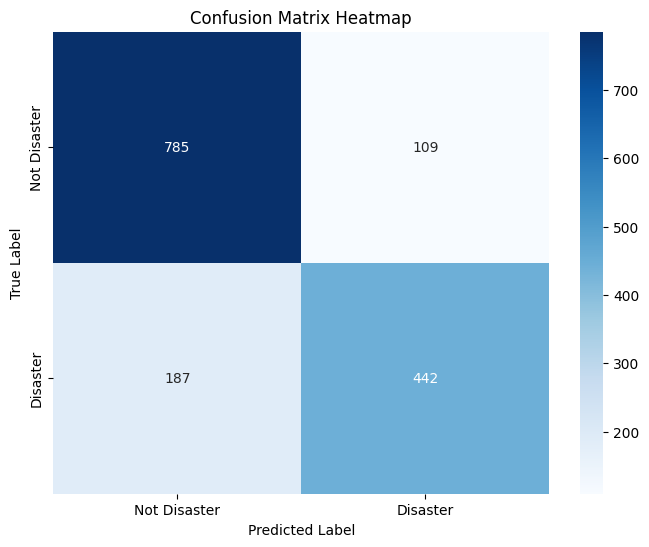

In [19]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


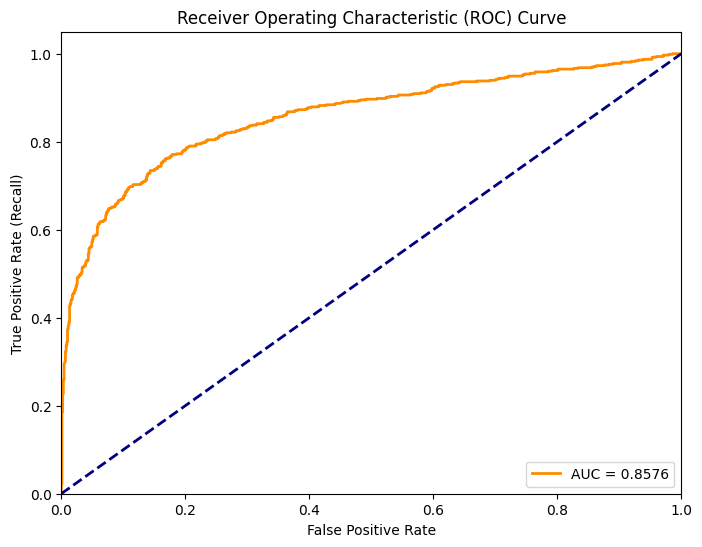

In [20]:
# ROC Curve of BiLSTM model
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkorange', lw=2)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


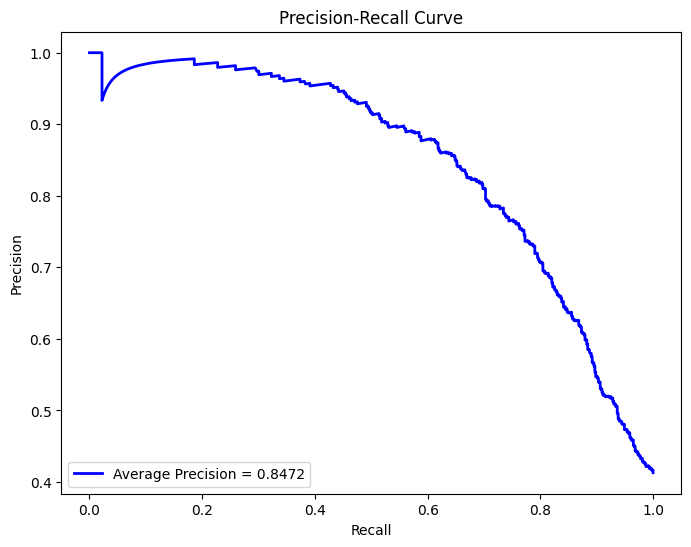

In [21]:
# Precision-Recall Curve of BiLSTM model
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)

plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, label=f'Average Precision = {avg_precision:.4f}', color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


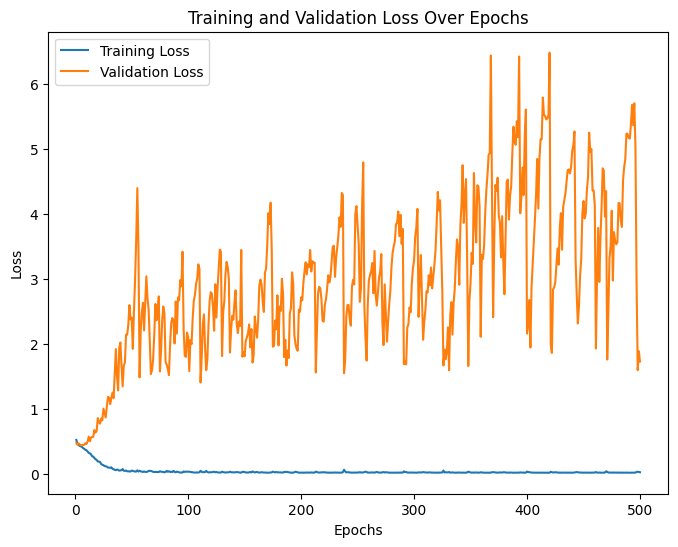

In [22]:
# Training and Validation Loss Curves of BiLSTM model
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_losses_epoch, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [23]:
# Create DataLoader for test set
test_data = TensorDataset(torch.from_numpy(test_padded))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize hidden state
net.eval()
test_preds = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0]
        if train_on_gpu:
            inputs = inputs.cuda()
        else:
            inputs = inputs

        h = net.init_hidden(inputs.size(0), train_on_gpu)
        h = tuple([each.data for each in h])

        outputs, h = net(inputs, h)

        preds = torch.round(outputs.squeeze())
        test_preds.extend(preds.detach().cpu().numpy())

# Ensure the number of predictions matches test set size
test_preds = test_preds[:len(test)]


In [24]:
# Save weights_matrix to a file
np.save('weights_matrix.npy', weights_matrix.numpy())


In [25]:
pip install streamlit pyngrok


In [26]:
# Install necessary packages

# Authenticate ngrok
from pyngrok import ngrok
ngrok.set_auth_token('2mdzC5PhaSZt0Kh7DcRfqbT4pfK_366JmJjiSDP9qLC8ZrTSH')  # Replace with your actual token


In [27]:
# Run the Streamlit app
import subprocess
import threading

def run_app():
    subprocess.call(['streamlit', 'run', 'app.py', '--server.port', '8501', '--server.headless', 'true'])

thread = threading.Thread(target=run_app)
thread.start()

# Expose the app using ngrok
public_url = ngrok.connect(8501)
print(f'Access your app at: {public_url}')


Access your app at: NgrokTunnel: "https://6b7c-34-53-4-121.ngrok-free.app" -> "http://localhost:8501"



# Instructions to Run the Notebook

1. Install Required Packages
```bash
pip install torch torchvision matplotlib
```

2. Load the Notebook and Execute All Cells
- Make sure you select a GPU if available (Runtime -> Change runtime type -> GPU).

3. Structure:
- First, the dataset is loaded.
- Next, both a Baseline Logistic Regression model and your Custom Model are defined.
- Both models are trained and evaluated separately.
- Results are visualized for easy comparison.

4. Outputs
- Check the training/validation loss and accuracy printed per epoch.
- Final test set performance will be printed.
- A bar plot compares Train/Validation/Test Accuracy for the baseline model.
